In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import re
import itertools
import time
import joblib
import random

import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = 15
pd.options.display.max_colwidth = -1
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import auc, roc_curve, make_scorer
from sklearn import svm, ensemble, datasets

In [3]:
import parsl
parsl.clear()

from polyfuse.configs.local import config
parsl.load(config)

#parsl.load()

from polyfuse import apps, transformations

In [4]:
out_dir = '/cephfs/users/annawoodard/polyfuse/data/sim_50/processed'
training_fraction = 0.85

In [5]:
truth = apps.concatenate_true_fusions('/cephfs/users/annawoodard/fusion-simulation/data/processed/*', out_dir)

In [6]:
truth = pd.read_hdf(truth.result(), 'data')

In [7]:
callers = ['starseqr', 'starfusion', 'arriba', 'fusioncatcher', 'pizzly']

In [61]:
parsed_caller_data = apps.parse_caller_data(out_dir, callers)

In [62]:
caller_data_path = apps.concatenate_caller_data(out_dir, inputs=parsed_caller_data)
caller_data = pd.read_hdf(caller_data_path.result(), 'data')

In [63]:
samples = sorted(caller_data['sample'].unique())
#random.shuffle(samples)
training_samples = samples[:int(len(samples) * training_fraction)]
testing_samples = samples[int(len(samples) * training_fraction):]

In [78]:
start = time.time()
x_train, y_train = apps.assemble_data(training_samples, callers, out_dir)
print('assembled data in {:.1f}s'.format((time.time() - start)))

assembled data in 68.6s


fit models in 186.0s


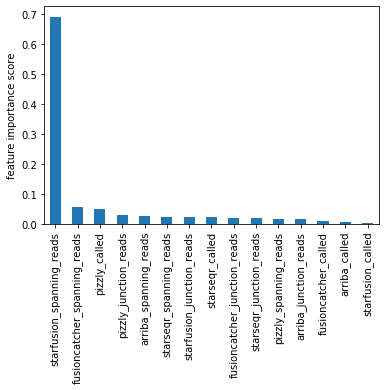

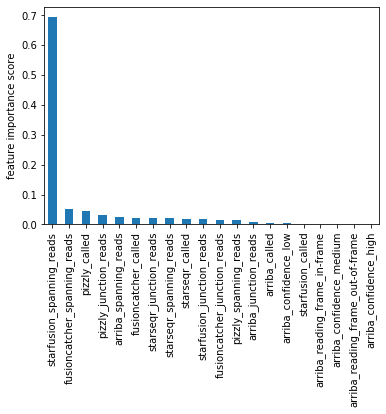

In [88]:
start = time.time()
os.makedirs(os.path.join(out_dir, 'models'), exist_ok=True)

base_columns = []
for c in callers:
    base_columns += [c + '_called', c + '_spanning_reads', c + '_junction_reads']
classifiers = []
for features in [
            base_columns,
            base_columns + [
                'arriba_confidence_high', 'arriba_confidence_low', 'arriba_confidence_medium',
                'arriba_reading_frame_in-frame', 'arriba_reading_frame_out-of-frame'
            ],
        ]:
    #label = 'LSVC{}features'.format(len(features))
    #trans = 'flatten'
    #classifier = svm.LinearSVC(probability=True)
    #print(label, classifier.get_params())
    #classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    #joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    #classifiers += [(features, label, trans)]


    #label = 'DefaultSVC{}features'.format(len(features))
    #trans = 'flatten'
    #classifier = svm.SVC(probability=True)
    #classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    #joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    #classifiers += [(features, label, trans)]

    #label = 'SVC{}Features'.format(len(features))
    #trans = 'flatten'
    #classifier = svm.SVC(C=10, gamma='auto', probability=True)
    #print(label, classifier.get_params())
    #classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    #joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    #classifiers += [(features, label, trans)]
    
    label = 'RFC{}F'.format(len(features))
    trans = 'noop'
    classifier = ensemble.RandomForestClassifier()
    classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    classifiers += [(features, label, trans)]

    
    label = 'GBC{}F'.format(len(features))
    trans = 'noop'
    classifier = ensemble.GradientBoostingClassifier(learning_rate=0.05, n_estimators=750, subsample=0.9)
    classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    classifiers += [(features, label, trans)]
    
    plt.figure()
    feature_importances = pd.Series(classifier.feature_importances_, features).sort_values(ascending=False)
    feature_importances.plot(kind='bar')
    plt.ylabel('feature importance score')

    label = 'DefaultGBC{}F'.format(len(features))
    trans = 'noop'
    classifier = ensemble.GradientBoostingClassifier()
    classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    classifiers += [(features, label, trans)]
    

print('fit models in {:.1f}s'.format((time.time() - start)))

In [80]:
x_train.shape, sum(y_train)

((63025, 23), 34000)

In [81]:
start = time.time()
model_data = pd.read_hdf(
    apps.predict(testing_samples, out_dir, classifiers, callers), 'data'
)
print('assembled predictions in {:.1f}s'.format((time.time() - start)))

assembled predictions in 70.6s


In [82]:
summary = apps.make_summary(out_dir, testing_samples)

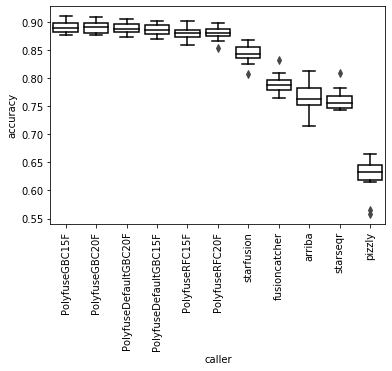

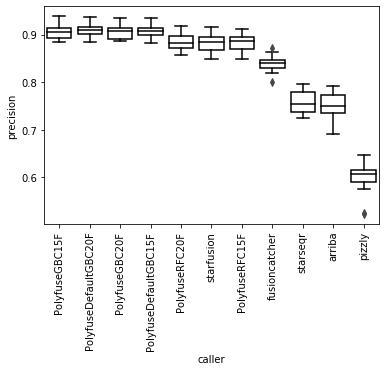

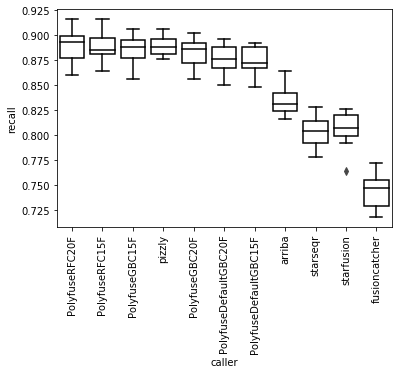

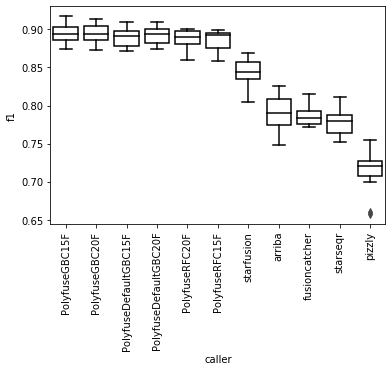

In [83]:
os.makedirs('plots', exist_ok=True)
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    plt.figure()
    ax = sns.boxplot(x="caller", y=metric, data=summary.sort_values(by=metric, ascending=False))
    labels = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    _ = plt.setp(ax.artists, edgecolor = 'k', facecolor='w')
    _ = plt.setp(ax.lines, color='k')
    plt.savefig('plots/{}.pdf'.format(metric))

In [84]:
summary.groupby('caller').mean().sort_values(by='accuracy', ascending=False)

,tp,fp,fn,tn,recall,precision,accuracy,f1,mcc
caller,,,,,,,,,
PolyfuseGBC15F,442.500000,46.333333,57.500000,406.750000,0.885000,0.905400,0.891131,0.895001,0.781751
PolyfuseGBC20F,441.083333,45.583333,58.916667,407.500000,0.882167,0.906508,0.890392,0.894084,0.780458
PolyfuseDefaultGBC20F,437.500000,43.500000,62.500000,409.583333,0.875000,0.909676,0.888802,0.891936,0.777595
PolyfuseDefaultGBC15F,436.750000,45.000000,63.250000,408.083333,0.873500,0.906752,0.886455,0.889740,0.772860
PolyfuseRFC20F,444.250000,58.500000,55.750000,394.583333,0.888500,0.883877,0.880185,0.886073,0.759207
PolyfuseRFC15F,443.833333,58.833333,56.166667,394.250000,0.887667,0.883200,0.879386,0.885336,0.757570
starfusion,403.083333,53.166667,96.916667,399.916667,0.806167,0.883525,0.842497,0.843047,0.687987
fusioncatcher,371.500000,71.750000,128.500000,381.333333,0.743000,0.838430,0.789370,0.787688,0.583872
arriba,417.500000,141.500000,82.500000,311.583333,0.835000,0.747741,0.764998,0.788789,0.528833


PolyfuseRFC10F
PolyfuseGBC10F
PolyfuseDefaultGBC10F
PolyfuseRFC15F
PolyfuseGBC15F
PolyfuseDefaultGBC15F


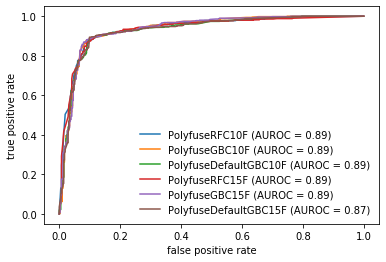

In [77]:
sample = model_data['sample'].unique()[0]
plt.figure()
for caller in model_data.caller.unique():
    print(caller)
    try:
        y_true, y_pred, y_prob = apps.score_model(out_dir, sample, caller).result()
    except:
        continue

    auroc = metrics.roc_auc_score(y_true, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, label='{} (AUROC = {:0.2f})'.format(caller, auroc))

plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(frameon=False)

PolyfuseRFC4F
PolyfuseGBC4F
PolyfuseDefaultGBC4F
PolyfuseRFC7F
PolyfuseGBC7F
PolyfuseDefaultGBC7F


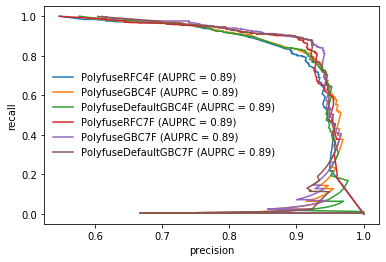

In [27]:
sample = model_data['sample'].unique()[0]
plt.figure()
for caller in model_data.caller.unique():
    print(caller)
    try:
        y_true, y_pred, y_prob = apps.score_model(out_dir, sample, caller).result()
    except:
        continue

    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_prob)
    auprc = auc(recall, precision)
    plt.plot(precision, recall, label='{} (AUPRC = {:0.2f})'.format(caller, auroc))

plt.xlabel('precision')
plt.ylabel('recall')
plt.legend(frameon=False)
# looks funky, but see: https://stats.stackexchange.com/questions/183504/are-precision-and-recall-supposed-to-be-monotonic-to-classification-threshold

In [39]:
data = pd.read_pickle('/cephfs/users/annawoodard/polyfuse/data/sim_50/processed/LIB-04674wt/arriba/fusions.pkl')

In [40]:
data

,gene1,gene2,strand1(gene/fusion),strand2(gene/fusion),breakpoint1,breakpoint2,site1,site2,type,direction1,direction2,split_reads1,split_reads2,discordant_mates,coverage1,coverage2,confidence,closest_genomic_breakpoint1,closest_genomic_breakpoint2,filters,fusion_transcript,reading_frame,peptide_sequence,read_identifiers,fusion,junction_reads,spanning_reads,caller,sample
0,SRCAP,FAM228A,+/+,+/+,16:30720331,2:24179111,splice-site,splice-site,translocation,downstream,upstream,301,294,300,1624,2064,high,.,.,"duplicates(37),low_entropy(34),mismatches(2)",CGCTGCAGGCTCTCCAAGCGTCAACGCTGTCTCTATGATGACTTCATGGC...ACACTAGCCACAGGCCATTTCATGAGCGTCATCAACATTTTGATGCAGCTGAGAAAAGTTTGCAATCATCCAAATCTGTTCGACCCTCGACCGGTTACCTCCCCTTTCATCACCCCAGGCATCTGCTTCAGCACCGCCTCTCTGGTGCTAAGGGCCACGGATGTCCATCCCCTCCAG___CGGATAGACATGGGTCGATTTGACCTTATTGGCCTGGAAGGTCGTGTCTCTCGATATGAGGCAGACACATTTCTGCCCCGGCACCGCCTCTCTCGCCGGGTACTGTTAGAAGTGGCTACTGCTCCTGACCCCCCACCCCGGCCCAAGCCAGTCAAGATGAAGGTCAACAG|AGATTGGATATGTATTTTCAGCATGTGGATACTTTTAAGGAAAGAAGAAAAGAGATGTTACATAAAAAATGGGTTGAAAATGTTGCAGAGCCTCTTCAGCAGAGAATTATGGAAAAAGTAATTTCATATAAAGAGCTTAAAATGAAACGAGAATGTTGAATATTATTTACAGCACAGACATAAAATG___GTTACAGTCCCACCATTTGTTGATCCTCTGTTTCAAAGACAGCAAGAGGTGGATGAAGAGAGGAGAACTGGTCTTCAGTGTGAGACAG___GAAAACGACATTCCATAAAAGAACTTGAAGAAATAGAGAAGGCCAGGCTGCATGCCAGCTCGCCCTACTTCACTTTCACTTCACACTGTGTGATTCCAAAAGAGTGGCATAAAGCCTCTGCAAGAGCCAGGAGTAAAA,out-of-frame,TLATGHFMSVINILMQLRKVCNHPNLFDPRPVTSPFITPGICFSTASLVLRATDVHPLQRIDMGRFDLIGLEGRVSRYEADTFLPRHRLSRRVLLEVATAPDPPPRPKPVKMKVNr|dwicifsmwillrkeekrcyiknglkmlqslfsrelwkk*,.,FAM228A--SRCAP,595,300,arriba,LIB-04674wt
1,CCL7,VPS29,+/+,-/-,17:34271263,12:110496203,splice-site,splice-site,translocation,downstream,downstream,294,300,300,1303,1270,high,.,.,"duplicates(31),low_entropy(29),mismatches(8)",GAGGGGCTGAGACCAAACCAGAAACCTCCAATTCTCATGTGGAAGCCCATGCCCTCACCCTCCAACATGAAAGCCTCTGCAGCACTTCTGTGTCTGCTGCTCACAGCAGCTGCTTTCAGCCCCCAGGGGCTTGCTCAGCCAG___AAAGACCCAGGACACACCCTCAATGGACTTTTCTTCTTGTTGTTTCATTGCAGTTGGGATTAATACTTCAACTACCTGCTGCTACAGATTTATCAATAAGAAAATCCCTAAGCAGAGGCTGGAGAGCTACAGAAGGACCACCAGTAGCCACTGTCCCCGGGAAGCTGTAAT|TTGGTGTTGGTATTAGGAGATCTGCACATCCCACACCGGTGCAACAGTTTGCCAGCTAAATTCAAAAAACTCCTGGTGCCAGGAAAAATTCAGCACATTCTCTGCACAGGAAACCTTTGCACCAAAGAGAGTTATGACTATCTCAAGACTCTGGCTGGTGATGTTCATATTGTGAGAGGAGACTTCGATGAG___AATCTGAATTATCCAGAACAGAAAGTTGTGACTGTTGGACAGTTCAAAATTGGTCTGATCCATGGACATCAAGTTATTCCATGGGGAGATATGGCCAGCTTAGCCCTGTTGCAGAGGCAATTTGATGTGGACATTCTTATCTCGGGACACACACACAAAT,out-of-frame,MKASAALLCLLLTAAAFSPQGLAQPERPRTHPQWTFLLVVSLQLGLILQLPAATDLSIRKSLSRGWRATEGPPVATVPGKL*|fgvgirrsahptpvqqfas*,.,CCL7--VPS29,594,300,arriba,LIB-04674wt
2,RNPEP,TMEM39B,+/+,+/+,1:201997554,1:32074951,splice-site,splice-site,duplication,downstream,upstream,286,290,300,1922,1727,high,.,.,"duplicates(26),low_entropy(16),mismatches(9)",ATTGATGCTGCCAAGGAGGAGTACAACGGGGTGATAGAAGAATTTTTGGCAACAGGAGAGAAGCTTTTTGGACCTTATGTTTGGGGAAG___GTATGACTTGCTCTTCATGCCACCGTCCTTTCCATTTGGAGGAATGGAGAACCCTTGTCTGACCTTTGTCACCCCCTGCCTGCTAGCTGGGGACCGCTCCTTGGCAGATGTCATCATCCATGAGATCTCCCACAGTTGGTTTGGGAACCTGGTCACCAACGCCAACTGGGGTGAATTCTGGCTCAATGAAGGTTTCACCATGTACGCCCAGAGGAGGATCTCCACCATCCTCTTTG|GAGGACGAAGAGGTCCCAACAGGACATCTTACTGTCGAAATCCGCTCTGTGAGCCGGGATCCTCGGGGGGCTCTAGTGGAAGCCACACTTCCAGTGCATCGGTGACCAGTGTTCGTTCCCGCACCAG___GAGCAGTTCTGGAACAGGCCTCTCCAGCCCTCCTCTGGCCACCCAAACTGTTGTGCCTCTACAGCACTGCAAGATCCCCGAGCTGCCAGTCCAGGCCAGCATTCTGTTTGAGTTGCAGCTCTTCTTCTGCCAGCTCATAGCACTCTTCGTCCACTACATCAACATCTACAAGACAGTGTGGTGGTATCCACCTTCCCACCCACCCTCCCACACCTCCCTG___AACTTCCATCTGATCGACTTCAACTTGCTGA,in-frame,IDAAKEEYNGVIEEFLATGEKLFGPYVWGRYDLLFMPPSFPFGGMENPCLTFVTPCLLAGDRSLADVIIHEISHSWFGNLVTNANWGEFWLNEGFTMYAQRRISTILF|gGRRGPNRTSYCRNPLCEPGSSGGSSGSHTSSASVTSVRSRTRSSSGTGLSSPPLATQTVVPLQHCKIPELPVQASILFELQLFFCQLIALFVHYINIYKTVWWYPPSHPPSHTSLNFHLIDFNLL,.,RNPEP--TMEM39B,576,300,arriba,LIB-04674wt
3,GBF1,MRPL46,+/+,-/-,10:102362664,15:88464876,splice-site,splice-site,translocation,downstream,downstream,267,293,300,2750,1432,high,.,.,"duplicates(24),low_entropy(54),mismatches(2)",GCTGCTTCCCTGCGAGTATGC

In [91]:
data = pd.read_pickle("/cephfs/users/annawoodard/polyfuse/data/sim_50/processed/LIB-04656wt/starfusion/fusions.pkl")

In [93]:
data

#FusionName  JunctionReadCount  SpanningFragCount  \
0    MBOAT1--TRBV14      783                2334                
1    TOGARAM2--SLC51B    778                2291                
2    TCF20--FAM166A      751                2318                
3    SALL4--TMEFF2       704                2194                
4    CEACAM3--TEX261     818                2031                
..               ...     ...                 ...                
475  AL049834.1--SLC9A3  1                  2                   
476  IL10RA--BRSK2       1                  2                   
477  PSIP1--PRAMEF12     3                  0                   
478  LEP--SPATA31E1      2                  1                   
479  RPS11--AC012158.1   3                  0                   

              SpliceType                       LeftGene     LeftBreakpoint  \
0    ONLY_REF_SPLICE      MBOAT1^ENSG00000172197.11      chr6:20212136:-     
1    ONLY_REF_SPLICE      TOGARAM2^ENSG00000189350.12    chr2:29017956:+     
2    ONLY_REF_SPLICE      TCF20^ENSG00000100207.18       chr22:42209651:-    
3    ONLY_REF_SPLICE      SALL4^ENSG00000101115.13       chr20:51788861:-    
4    ONLY_REF_SPLICE      CEACAM3^ENSG00000170956.17     chr19:41797948:+    
..               ...                             ...                  ...    
475  ONLY_REF_SPLICE      AL049834.1^ENSG00000042317.17  chr14:88437597:+    
476  ONLY_REF_SPLICE      IL10RA^ENSG00000110324.10      chr11:117986534:+   
477  ONLY_REF_SPLICE      PSIP1^ENSG00000164985.15       chr9:15472632:-     
478  ONLY_REF_SPLICE      LEP^ENSG00000174697.5          chr7:128252162:+    
479  INCL_NON_REF_SPLICE  RPS11^ENSG00000142534.7        chr19:49497325:+    

                        RightGene   RightBreakpoint  \
0    TRBV14^ENSG00000275743.1      chr7:142588062:+   
1    SLC51B^ENSG00000186198.4      chr15:65051515:+   
2    FAM166A^ENSG00000188163.8     chr9:137245557:-   
3    TMEFF2^ENSG00000144339.12     chr2:192191989:-   
4    TEX261^ENSG00000144043.12     chr2:70991983:-    
..                         ...                 ...    
475  SLC9A3^ENSG00000066230.12     chr5:476092:-      
476  BRSK2^ENSG00000174672.16      chr11:1442490:+    
477  PRAMEF12^ENSG00000116726.4    chr1:12775543:+    
478  SPATA31E1^ENSG00000177992.10  chr9:87884913:+    
479  AC012158.1^ENSG00000243024.6  chr12:64396672:+   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [96]:
pd.options.display.max_rows = 15
fusion = 'UBE2QL1--GREB1'

In [99]:
caller_data.loc[caller_data.fusion == fusion, ['spanning_reads', 'junction_reads'].mean()

1268.2